## 02. PyTorch Neural Network Classification

https://www.learnpytorch.io/02_pytorch_classification/

### 1. 데이터셋 만들기

In [1]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
X.shape

(1000, 2)

In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [5]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [6]:
import matplotlib.pyplot as plt

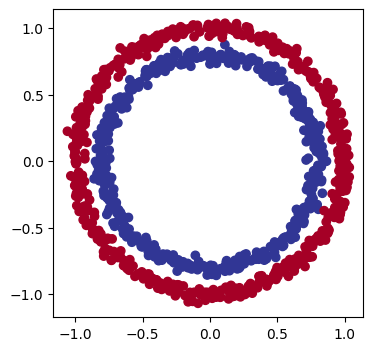

In [7]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(x = circles.X1, 
           y = circles.X2,
           c = y,
           cmap=plt.cm.RdYlBu)

데이터셋을 텐서로 만들고, 학습용/ 시험용으로 나눈다.

In [8]:
import torch

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X.dtype

torch.float32

In [11]:
type(X)

torch.Tensor

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Building model

다음 단계로 나눈다.  
- 디바이스 세팅
- nn.Module을 서브클래싱하여 모델 만들기  
- 손실함수, 옵티마이저 정의
- 학습루프 구동

- 디바이스 세팅

In [15]:
import torch
from torch import nn

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

- nn.Module을 서브클래싱하여 모델 만들기  
    - nn.Module 서브클래싱
    - nn.Linear 정의
    - forward 함수 정의
    - 모델을 타겟 device로 보내서 인스턴스화??? : 모델과 데이터 둘다 보내야...

In [17]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [21]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
next(model_0.parameters()).device

device(type='cpu')

또다른 구현방법

In [23]:
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                       nn.Linear(in_features=5, out_features=1)
                       ).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

우선 학습하지 않고 결과 확인

In [24]:
untrained_preds = model_0(X_test.to(device))
untrained_preds

tensor([[ 0.1874],
        [ 0.0292],
        [ 0.2516],
        [ 0.1706],
        [-0.3046],
        [-0.3968],
        [-0.4013],
        [-0.5025],
        [ 0.2750],
        [ 0.0125],
        [ 0.2413],
        [ 0.1169],
        [-0.4712],
        [ 0.1730],
        [ 0.3555],
        [-0.4163],
        [-0.1683],
        [ 0.3347],
        [ 0.2692],
        [ 0.3824],
        [ 0.0330],
        [-0.5419],
        [ 0.3018],
        [ 0.4012],
        [-0.2811],
        [-0.4358],
        [-0.0259],
        [-0.4988],
        [ 0.3938],
        [ 0.0888],
        [-0.2958],
        [-0.2517],
        [ 0.2165],
        [-0.1576],
        [ 0.2611],
        [-0.0367],
        [ 0.1478],
        [ 0.2017],
        [-0.0786],
        [ 0.1363],
        [ 0.3208],
        [ 0.3124],
        [-0.1758],
        [-0.3246],
        [ 0.2228],
        [-0.0680],
        [-0.3807],
        [ 0.0482],
        [-0.0062],
        [-0.3588],
        [ 0.1820],
        [ 0.2190],
        [-0.

In [25]:
untrained_preds.shape

torch.Size([200, 1])

In [26]:
y_test.shape

torch.Size([200])

- shape가 다르므로 계산시 reshape 필요

손실함수, 옵티마이져

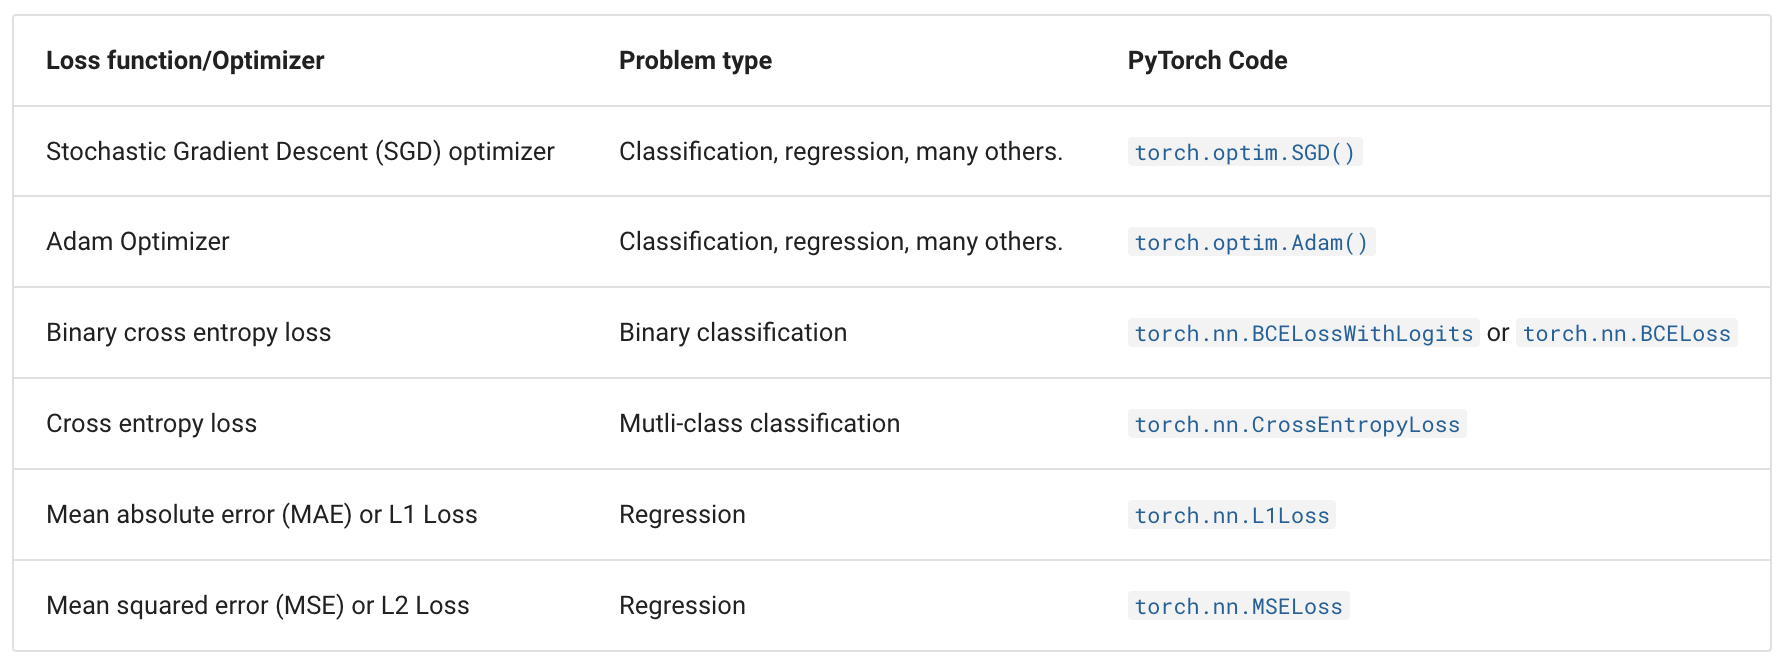

우리는 이진 분류를 고려하고 있기 때문에 이와 관련된 함수를 살펴보자.  
- torch.nn.BCELoss() : 타겟과 예측값 비교?
- torch.nn.BCEWithLogitsLoss() : 내부에 시그모이드 통과 시킨후 손실 계산. 따라서 시그모이드 입력 전 예측 값을 사용

torch.nn.BCEWithLogitsLoss()이 torch.nn.BCELoss()에 시그모이드를 통과시킨 출력을 비교하는 것 보다 안정적인 것으로 알려짐

In [28]:
loss_fn = nn.BCEWithLogitsLoss()# sigmoid built-in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

평가함수

In [29]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # item을 사용하면 스칼라를 리턴함. 뒤에 연산할때 에러가 발생안함
    acc = (correct / len(y_pred)) * 100 
    return acc

## 3. 모델 학습

1. Forward pass : The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).  
2. Calculate the loss : The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).  
3. Zero gradients : The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).  
4. Perform backpropagation on the loss : Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).  
5. Step the optimizer (gradient descent) : Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

그전에 모델 출력을 확인해보자.(시그모이드 입력전)

In [30]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1874],
        [ 0.0292],
        [ 0.2516],
        [ 0.1706],
        [-0.3046]], grad_fn=<SliceBackward0>)

In [31]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5467],
        [0.5073],
        [0.5626],
        [0.5426],
        [0.4244]], grad_fn=<SigmoidBackward0>)

- if y_pred_probs >= 0.5, y=1 (class 1)
- If y_pred_probs < 0.5, y=0 (class 0)

In [32]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 0.], grad_fn=<SqueezeBackward0>)

In [33]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

모델 학습, 시험루프

In [36]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [37]:
for epoch in range(epochs):
    model_0.train()
    
    y_logits = model_0(X_train).squeeze() # loss함수에 사용
    y_pred = torch.round(torch.sigmoid(y_logits)) # accuracy 계산을 위해 사용
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred = y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10== 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70577, Accuracy: 50.25% | Test loss: 0.70115, Test acc: 48.00%
Epoch: 10 | Loss: 0.70356, Accuracy: 50.38% | Test loss: 0.69933, Test acc: 48.00%
Epoch: 20 | Loss: 0.70187, Accuracy: 50.38% | Test loss: 0.69798, Test acc: 48.00%
Epoch: 30 | Loss: 0.70055, Accuracy: 50.25% | Test loss: 0.69695, Test acc: 47.50%
Epoch: 40 | Loss: 0.69949, Accuracy: 50.38% | Test loss: 0.69616, Test acc: 47.00%
Epoch: 50 | Loss: 0.69863, Accuracy: 50.25% | Test loss: 0.69555, Test acc: 47.00%
Epoch: 60 | Loss: 0.69792, Accuracy: 50.38% | Test loss: 0.69506, Test acc: 47.00%
Epoch: 70 | Loss: 0.69733, Accuracy: 50.38% | Test loss: 0.69468, Test acc: 47.00%
Epoch: 80 | Loss: 0.69684, Accuracy: 50.38% | Test loss: 0.69438, Test acc: 47.00%
Epoch: 90 | Loss: 0.69641, Accuracy: 50.38% | Test loss: 0.69413, Test acc: 47.00%


### 4. Make predictions and evaluate the model

In [38]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [40]:
from helper_functions import plot_predictions, plot_decision_boundary

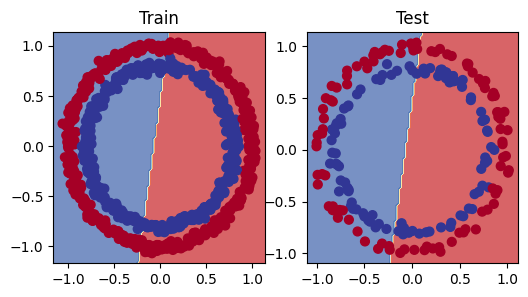

In [42]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

- underfitting

### 5. 모델 개선하기

모델 개선방안  
- 레이어늘리기
- 히든유닛 수 늘리기
- 에포크 늘리기
- 활성화 함수 바꾸기
- 학습률 조정
- 손실함수 조정
- 전이학습

In [43]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # 추가
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [44]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [45]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [46]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


- 성능이 더 좋아지지는 않았다.

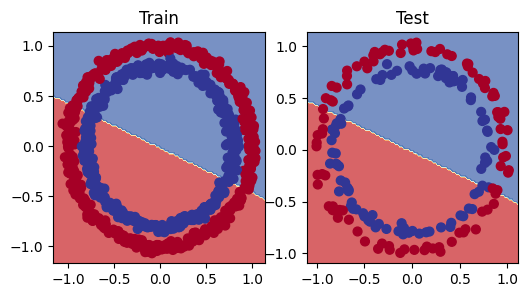

In [47]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

- 여전히 분류 경계를 직선으로 긋는다.

... 뒷부분 생략

### 6. The missing piece: non-linearity

비선형 데이터 다시 생성

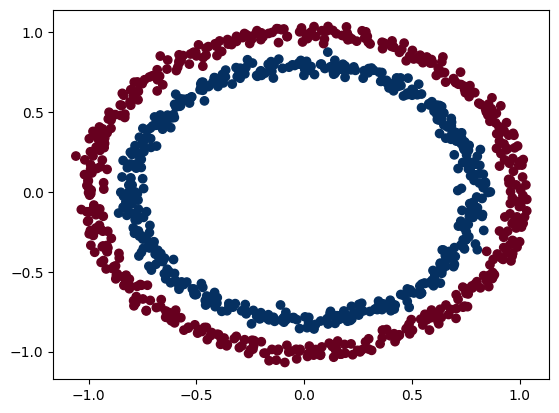

In [48]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [49]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

In [50]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [55]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


손실함수와 옵티마이저

In [56]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

다시 학습

In [57]:

# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


In [58]:
for epoch in range(epochs):
    # 1. forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    
    # 3. optimizer 초기화
    optimizer.zero_grad()
    
    # 4. 그레디언트 계산
    loss.backward()
    
    # 5. optimizer update
    optimizer.step()
    
    ## Test
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
        # 2. Calcuate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


평가

In [59]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

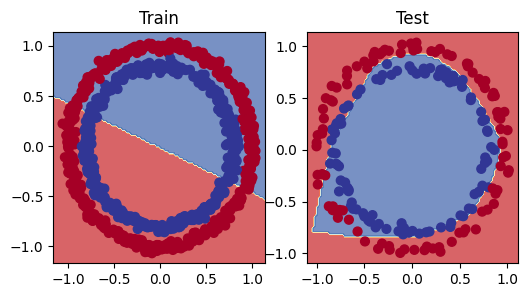

In [61]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

### 7. Replicating non-linear activation functions

### 8. Putting things together by building a multi-class PyTorch model

다중 분류 데이터 만들기   
- 1. make_blobs()로 만들기  
- 2. numpy 포맷을 텐서로 만들기  
- 3. 데이터 나누기
- 4. 시각화

In [62]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [63]:
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

In [64]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [65]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

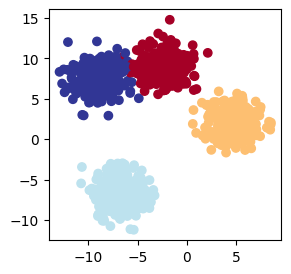

In [67]:
# 4. Plot data
plt.figure(figsize=(3, 3))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

모델 만들기  
- input_features, output_features, hidden_units를 인자로 만들자.

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [70]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features= hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
    
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

손실함수, 옵티마이저

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

학습전에 출력 형태 확인해보기

In [74]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [75]:
y_blob_train[:5]

tensor([1, 0, 2, 2, 0])

In [76]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


소프트맥스를 통과한 출력의 row sum은 1이다.

In [77]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [78]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


학습하기

In [80]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


평가하기

In [82]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


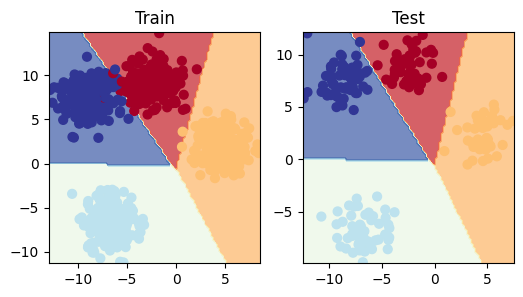

In [83]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9. More classification evaluation metrics

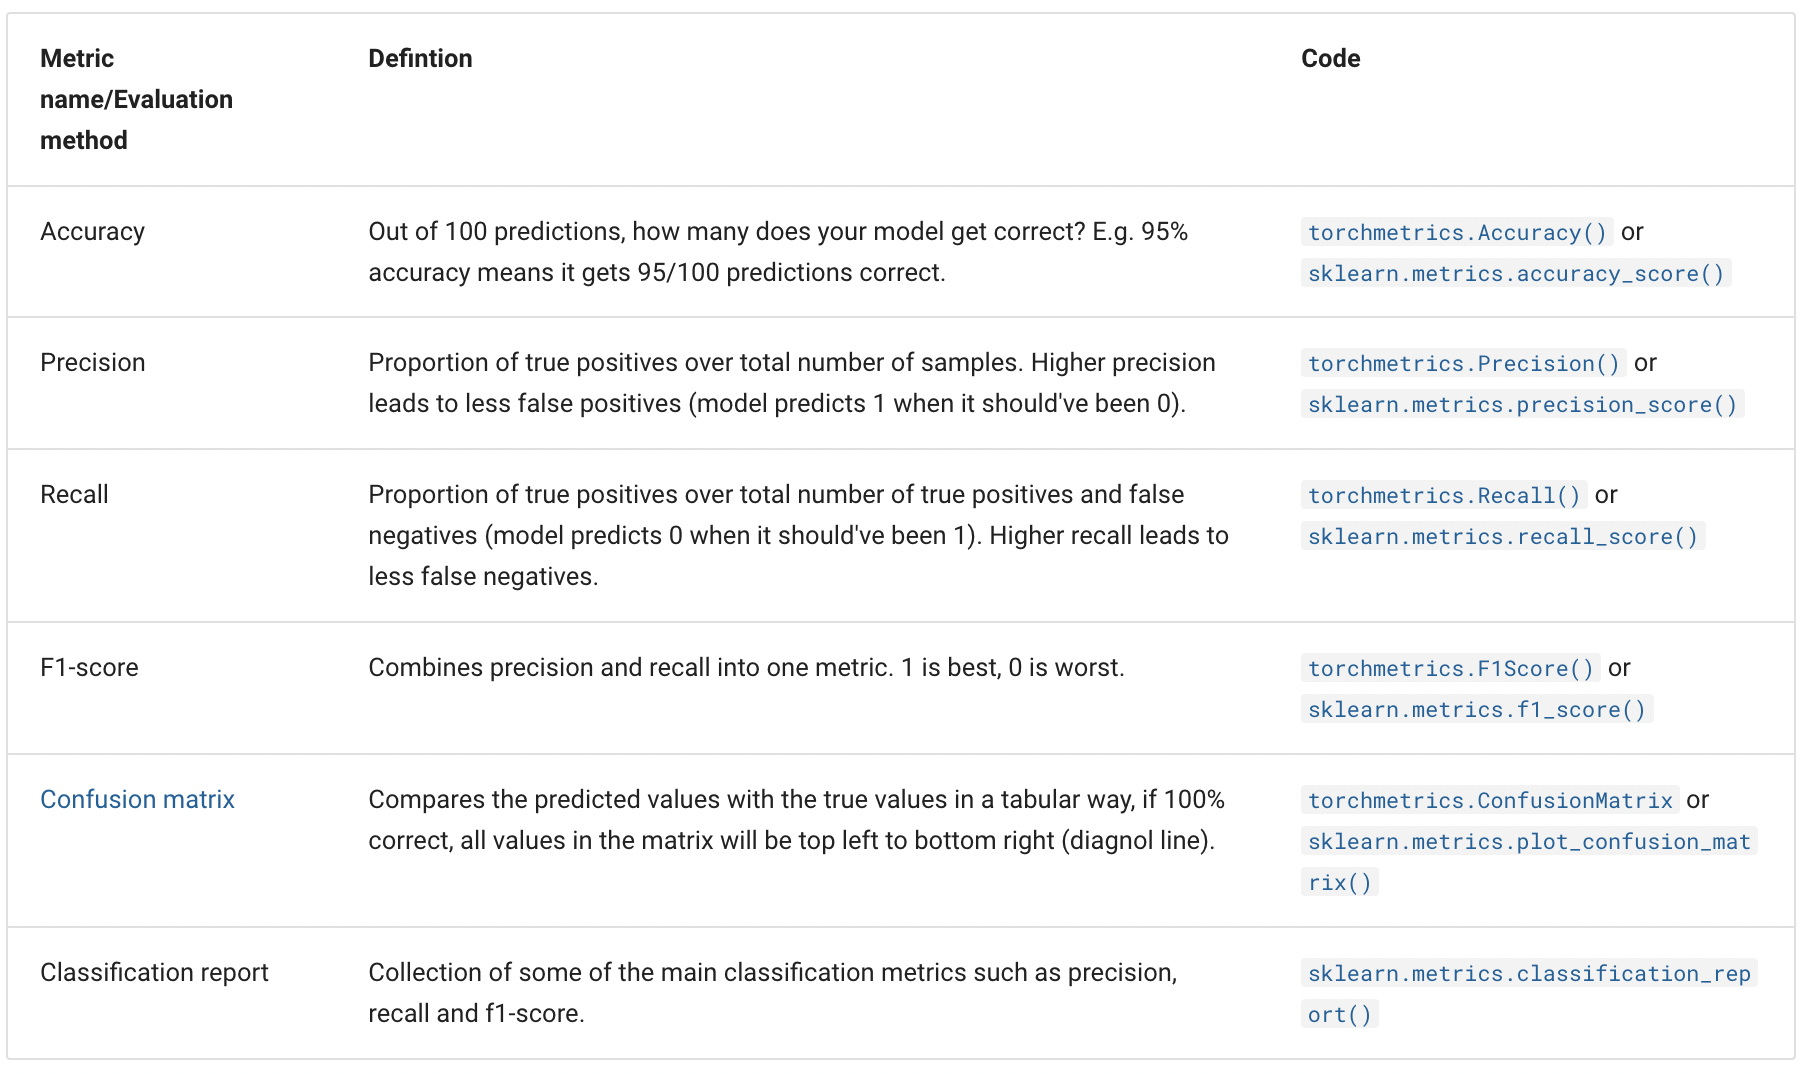

In [84]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 9.2 MB/s eta 0:00:000:00:01


tensor(0.9950)